# **Simple integration of DP Langevin equation**

Run a basic DP simulation. A time series of density field plots is generated and each image grid is exported as a PNG file: these PNGs are used to make a video.

<hr>

## Preliminaries

In [1]:
from essentials import *
dplvn.__version__

'2025.11.14a2'

In [2]:
density_dict: dict[float, NDArray] = {}
density_image_dict: dict[int, Any] = {}

<hr>

## Notes

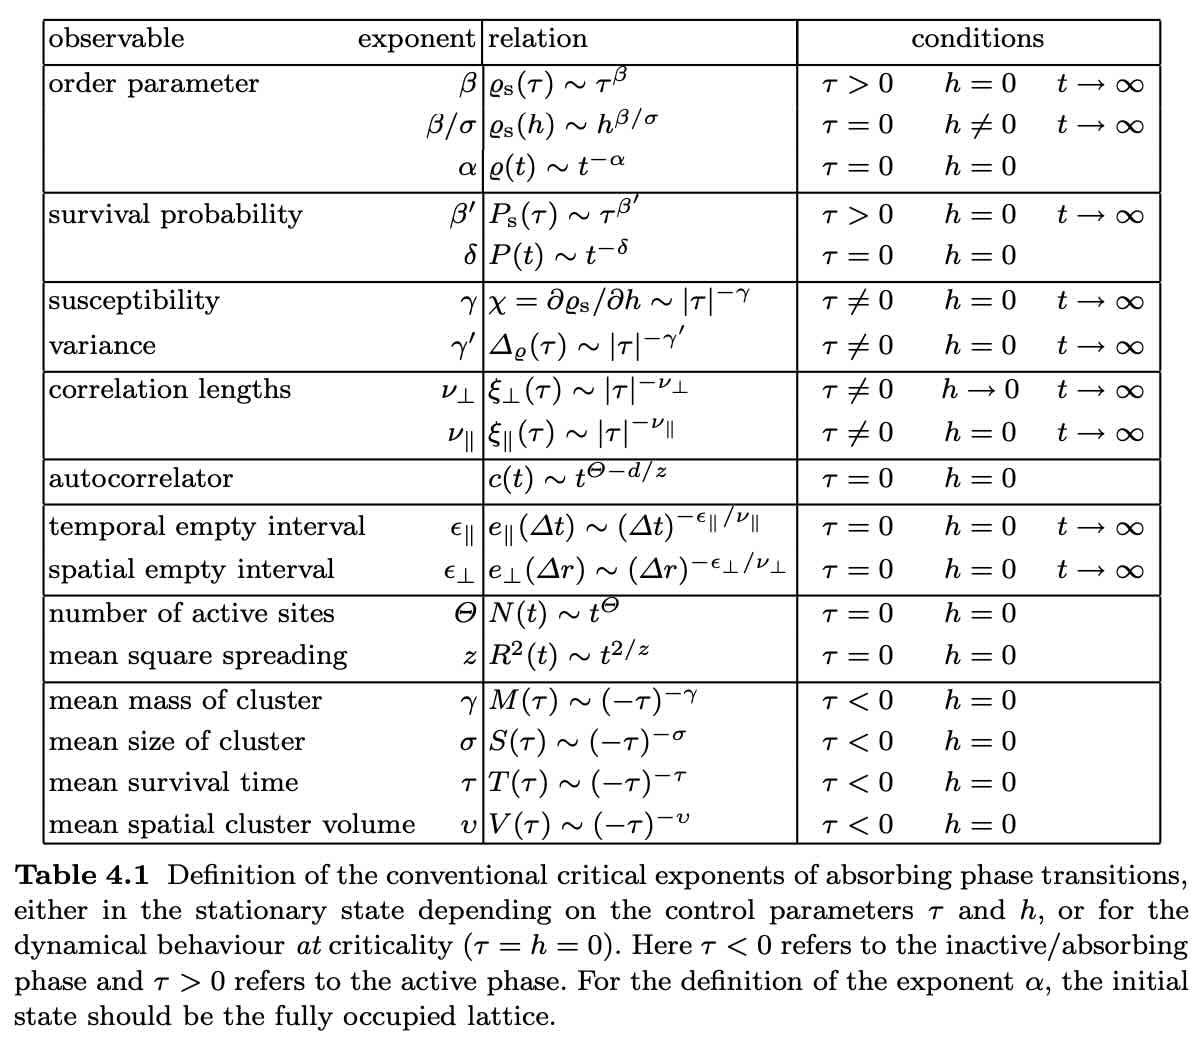

In [3]:
fetch_image(
    ("..","..","images",), "Henkel2008_Table4p1_APTScalingRelations.jpg",
)


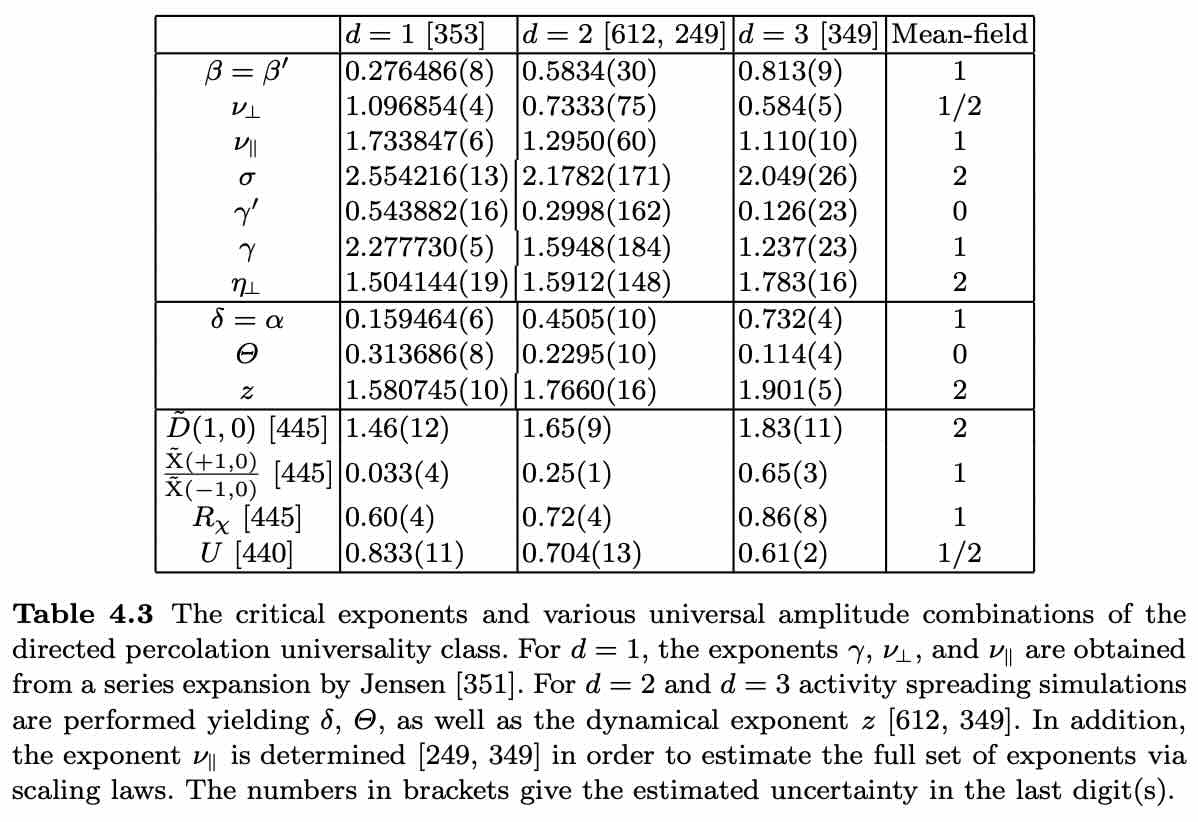

In [4]:
fetch_image(
    ("..","..","images",),"Henkel2008_Table4p3_DirectedPercolationScaling.jpg",
)


<hr>

## Parameters

In [5]:
random_seed: int = 1
sim_name_: str = "a1p18950_b1_D0p04_η1_x100_y50_Δx1_Δt0p1"
# sim_name_: str = "a1p18950_b1_D0p04_η1_x40_y25_Δx1_Δt0p1"
# sim_name_: str = "a1p18855_b1_D0p04_η1_x31_y31_Δx1_Δt0p1"
# sim_name_: str = "a1p18855_b1_D0p04_η1_x62_y62_Δx1_Δt0p1"
# sim_name_: str = "a1p18855_b1_D0p04_η1_x125_y125_Δx1_Δt0p1"
# sim_name_: str = "a1p18855_b1_D0p04_η1_x250_y250_Δx1_Δt0p1"
# sim_name_: str = "a1p18855_b1_D0p04_η1_x500_y500_Δx1_Δt0p1"
# sim_name_: str = "a1p18855_b1_D0p04_η1_x1000_y1000_Δx1_Δt0p1"
# sim_name_: str = "a1p18855_b1_D0p04_η1_x2000_y2000_Δx1_Δt0p1"
sim_name = sim_name_ #+ f"_rs{random_seed}"
sim_name

'a1p18950_b1_D0p04_η1_x100_y50_Δx1_Δt0p1'

In [6]:
info: dict = import_info(
    os.path.join(pardir, pardir, "experiments", sim_name,), 
    "Info", dplvn,
)
analysis: dict = info["Analysis"]
parameters: dict = info["Parameters"]
misc: dict = info["Misc"]
# if sim_name!=set_name(parameters, analysis,):
#     raise NameError

In [7]:
analysis.update({
    "dp_β": 0.584,
    "dp_ν_pp": 0.734,
    "dp_ν_ll": 1.295,
    "dp_δ": 0.451,
})
make_dataframe(analysis)

,value
name,
a_c,1.18857
dp_β,0.58400
dp_ν_pp,0.73400
dp_ν_ll,1.29500
dp_δ,0.45100


In [8]:
#   linear=1.18850, quadratic=1, diffusion=0.04, noise=1, dx=1, 
# linear=1.18900, quadratic=1, diffusion=0.04, noise=1, dx=1, 
# linear=1.18850, quadratic=1, diffusion=0.01, noise=1, dx=0.5, 
# linear=2.2140, quadratic=1, diffusion=0.1, noise=2*np.sqrt(2),
# linear=1.61, quadratic=1.61, diffusion=0.04, noise=1*1.414,
# linear=1.0, quadratic=2.0, diffusion=0.1, noise=1.1564,
make_dataframe(parameters)

,value
name,
linear,1.1895
quadratic,1
diffusion,0.04
noise,1
dx,1
dt,0.1
t_final,300.0
random_seed,1
grid_dimension,GridDimension.D2


In [9]:
misc["dplvn_version"] = dplvn.__version__
misc["n_round_Δt_summation"] = 15
misc["date_time"] = datetime.now().replace(microsecond=0).isoformat(sep=" ")
make_dataframe(misc)

,value
name,
n_sims,1
Δa_range,0.01
n_round_Δt_summation,15
n_segments,300
n_digits,6
do_export_combo_graphs,False
do_export_combo_data,False
do_export_graphs,True
do_export_data,True


<hr>

## Simulation

In [10]:
sim = dplvn.SimDP(**parameters, do_snapshot_grid=True,)

In [11]:
if not sim.initialize(misc["n_round_Δt_summation"]):
    raise Exception("Failed to initialize sim")
t_epochs: NDArray
mean_densities: NDArray
analysis["n_epochs"] = sim.get_n_epochs()
print(f"Number of sim epochs = {analysis["n_epochs"]}")

Number of sim epochs = 3001


In [12]:
def run_sim(n_segments: int=500) -> tuple[NDArray, NDArray]:
    n_epochs: int = sim.get_n_epochs()
    n_segment_epochs: int = (n_epochs-1) // n_segments
    if (n_segment_epochs*n_segments+1)!=n_epochs:
        raise Exception(
            f"Failed to segment sim with {n_epochs} epochs "
            + f"into {n_segments} segment(s)"
        )
    t_epoch_: int
    i_segment_: int
    for i_segment_ in progress(range(0, n_segments+1, 1)):
        if i_segment_>0 and not sim.run(n_segment_epochs):
            raise Exception("Failed to run sim")
        if not sim.postprocess():
            raise Exception("Failed to process sim results")
        # i_epoch = sim.get_i_current_epoch()
        t_epoch_ = sim.get_t_current_epoch()
        density_dict[t_epoch_] = sim.get_density()
    return (sim.get_t_epochs(), sim.get_mean_densities(),)

In [13]:
tick: float = perf_counter()
%time (t_epochs, mean_densities,) = run_sim(misc["n_segments"])
tock: float = perf_counter()

100%|██████████| 301/301 [00:02<00:00, 120.70it/s]


CPU times: user 2.49 s, sys: 12 ms, total: 2.5 s
Wall time: 2.5 s


In [14]:
misc["computation_time"] = f"{timedelta(seconds=round(tock-tick))}"
print(f"Computation time = {misc["computation_time"]}")

Computation time = 0:00:02


<hr>

## Plot

In [15]:
graphs = VizDP()
images = VizDP()

Plot the time-series of grid-averaged density field:

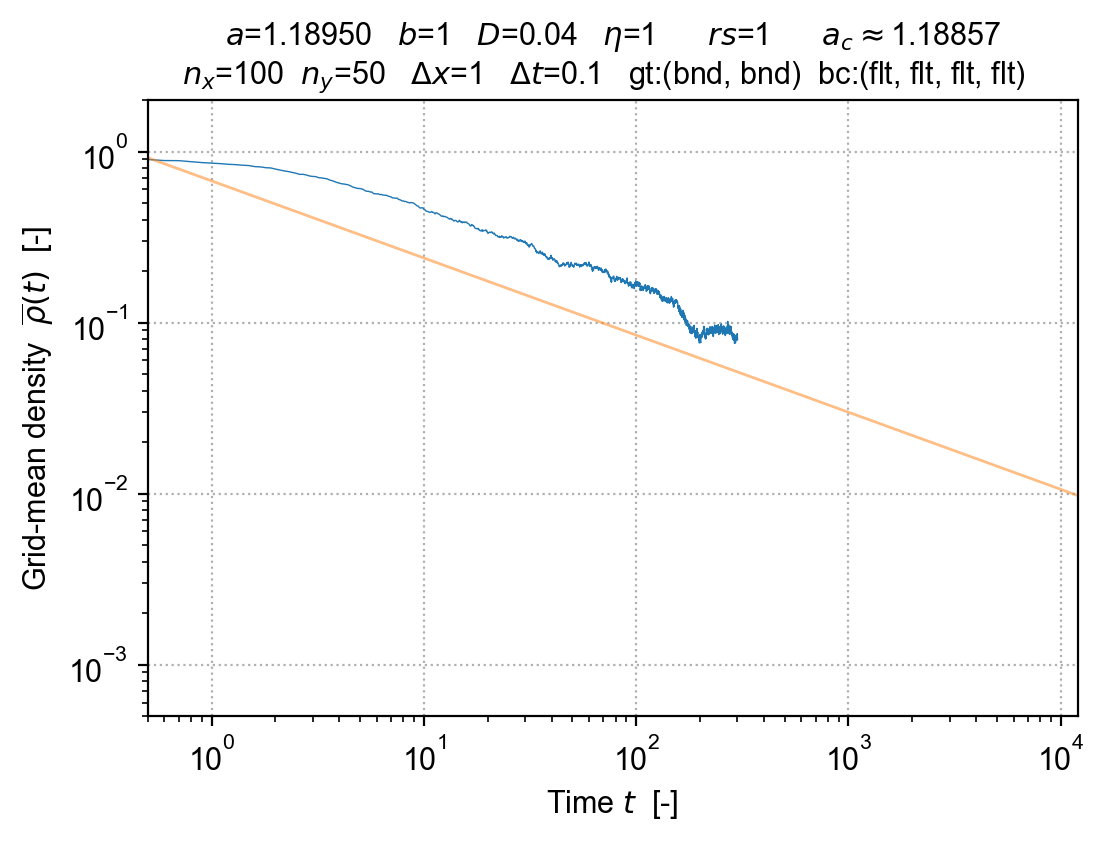

In [16]:
graphs.plot_mean_density_evolution(
    set_name(
        parameters, analysis, "ρ_t", 
        suffix=f"_rs{parameters["random_seed"]}"+"_loglog",
    ), 
    parameters, analysis, misc, 
    t_epochs, mean_densities, 
    do_rescale=False, y_sf=0.75,
)

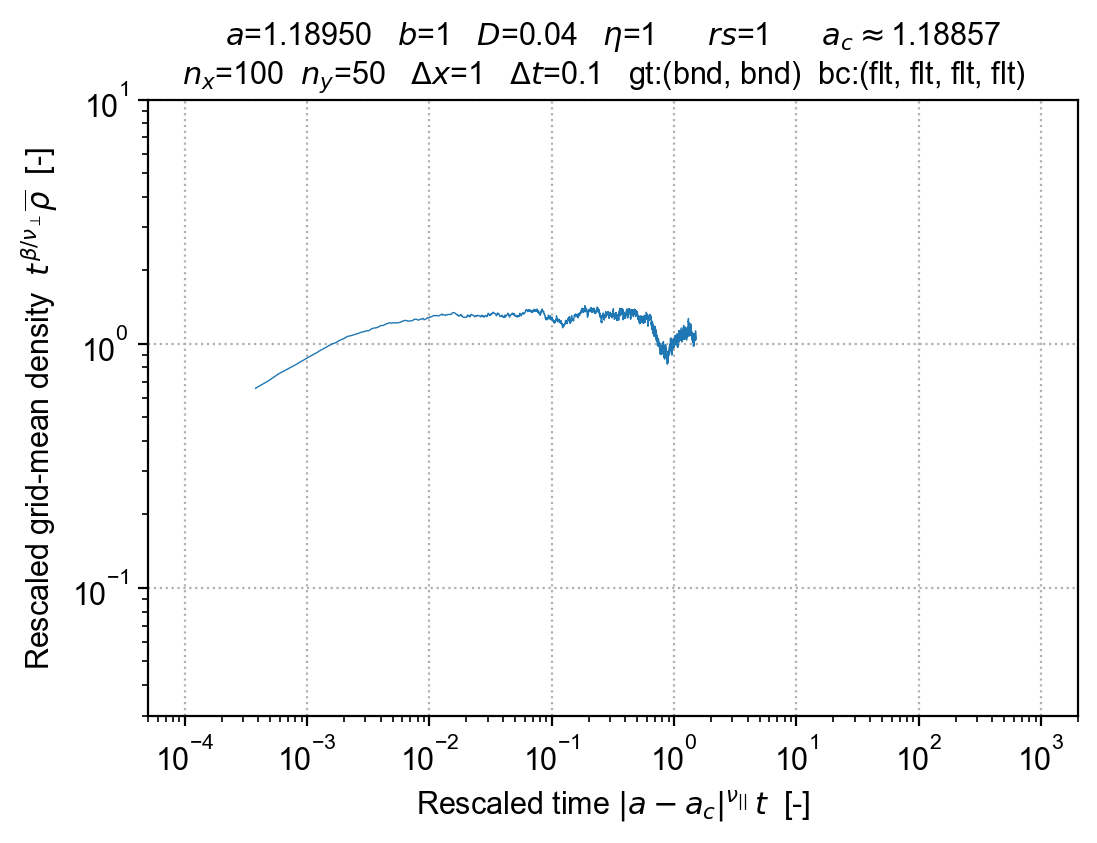

In [17]:
graphs.plot_mean_density_evolution(
    set_name(parameters, analysis, "ρ_t",
             suffix=f"_rs{parameters["random_seed"]}"+"_rescaled",),
    parameters, analysis, misc,
    t_epochs, mean_densities, 
    do_rescale=True,
)

In [18]:
# graphs.plot_mean_density_evolution(
#     set_name(parameters, analysis, "ρ_t", "_linear"), 
#     parameters, results, misc,
#     t_epochs, mean_densities, 
#     do_loglog=False, do_rescale=False, y_sf=0.75,
# )

Plot image grids of density field time-slices:

In [19]:
n_digits: int = misc["n_digits"]
name_: str 
density_: NDArray
for i_epoch_, t_epoch_ in progress(enumerate(density_dict.keys())):
    name_ =  f"ρ_t{t_epoch_:0{n_digits}.1f}".replace(".","p")
    # print(i_epoch_, t_epoch_, name_)
    density_ = density_dict[t_epoch_]
    density_image_dict[i_epoch_] = images.plot_density_image(
        name_, 
        parameters, 
        analysis,
        t_epoch_, 
        density_, 
        density_max=3,
        tick_Δρ=1,
        do_extend_if_periodic=False,
        n_digits=n_digits,
    )

301it [00:03, 95.98it/s] 


<hr>

## Save

In [20]:
sim_dir_name: str = sim_name

outfo: dict = {
    "Parameters" : parameters,
    "Analysis" : analysis,
    "Misc" : misc
}
serializable_outfo: dict
(serializable_outfo, _,) = export_info(
    create_directories((pardir, pardir, "experiments",), sim_dir_name,), 
    "Outfo", outfo, dplvn,
)
pp(serializable_outfo)

{   'Analysis': {   'a_c': 1.18857,
                    'dp_β': 0.584,
                    'dp_δ': 0.451,
                    'dp_ν_ll': 1.295,
                    'dp_ν_pp': 0.734,
                    'n_epochs': 3001},
    'Misc': {   'computation_time': '0:00:02',
                'date_time': '2025-11-19 14:01:45',
                'do_export_combo_data': False,
                'do_export_combo_graphs': False,
                'do_export_data': True,
                'do_export_graphs': True,
                'do_export_images': True,
                'do_make_video': True,
                'dplvn_version': '2025.11.14a2',
                'n_digits': 6,
                'n_round_Δt_summation': 15,
                'n_segments': 300,
                'n_sims': 1,
                'video_format': 'mp4',
                'video_frame_rate': 50,
                'xlimits_log': [0.5, 12000.0],
                'xlimits_rescaled': [5e-05, 2000.0],
                'ylimits_log': [0.0005, 2.0],
        

In [21]:
graphs_path: str = export_plots(
    graphs.fdict, 
    create_directories(
        (pardir, pardir, "experiments", sim_dir_name,), 
        "Graphs",
    ),
)

In [22]:
data_path: str = create_directories(
    (pardir, pardir, "experiments", sim_dir_name,), "Data", do_clean=False,
)
np.savez_compressed(
    os.path.join(data_path, "ρ_t"+f"_rs{parameters["random_seed"]}"), 
    t_epochs=t_epochs,
    mean_densities=mean_densities,
)

In [23]:
data_npz: NpzFile = np.load(
    os.path.join(data_path, "ρ_t"+f"_rs{parameters["random_seed"]}"+".npz"), 
)
data_npz["t_epochs"][-10:], data_npz["mean_densities"][-10:]

(array([299.1, 299.2, 299.3, 299.4, 299.5, 299.6, 299.7, 299.8, 299.9,
        300. ]),
 array([0.08326647, 0.08191987, 0.08363494, 0.08500909, 0.08625438,
        0.08341971, 0.0820413 , 0.08104676, 0.07907051, 0.08034427]))

In [24]:
if "do_export_images" in misc and misc["do_export_images"]:
    images_path: str = export_plots(
        images.fdict, 
        create_directories(
            (pardir, pardir, "experiments", sim_dir_name,), 
            "Images", do_clean=True,
        ),
    )
    print(images_path)

./../../experiments/a1p18950_b1_D0p04_η1_x100_y50_Δx1_Δt0p1/Images


In [25]:
if "do_make_video" in misc and misc["do_make_video"]:
    videos_path: str = create_directories(
        (pardir, pardir, "experiments", sim_dir_name,), "Videos",
    )

    video_frame_rate: int = misc["video_frame_rate"]
    video_format: str = misc["video_format"]
    video_images_wildcard: str = "ρ_t"+"?"*n_digits+".png"
    input = ffmpeg.input( 
        os.path.join(images_path, video_images_wildcard), 
        pattern_type="glob", 
        framerate=video_frame_rate, 
        pix_fmt="yuv420p",
    )
    output = ffmpeg.output(
        input.video,
        os.path.join(
            videos_path, 
            f"ρ_{sim_dir_name}_rs{parameters["random_seed"]}.{video_format}"
        ),
        vf="crop=floor(iw/2)*2:floor(ih/2)*2",
        vcodec="libx264",
        format=video_format,
    )

In [27]:
if "do_make_video" in misc and misc["do_make_video"]:
    stderr_output: str = output.overwrite_output().run(capture_stderr=True,)
    # print(stderr_output)